# Imports

In [ ]:
!pip install EoN > /dev/null

In [ ]:
import time
import EoN
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from scipy.stats import spearmanr
import community as community_louvain

from IPython.display import HTML
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm


# Infection Spread Model

We define a class we all the necessary methods for the implementation and execution of the popular models for SIR endthe Gillespie for SEIR. There are functions for simulating and plotting the simulations, also with some metrics.

In [ ]:
class InfectionSpreadModel:
    def __init__(self,
                 # Network & simulation settings
                 graph=nx.barabasi_albert_graph(1000, 20),
                 model=EoN.fast_SIR,
                 tmin=0, tmax=200,
                 initially_infected_fraction=0.05,
                 num_simulations=20,
                 status_colors={'S':'#1CA9A9','I':'#E63946','R':'#F4A261','E':'#171C6F'},
                 # Disease parameters
                 recovery_rate=1.0,
                 transmission_rate=0.3,
                 TE=7, TI=14, rho=0.1,
                 # Timing functions (Markovian)
                 trans_time_fxn=lambda infected, susceptible, *args: random.expovariate(args[0]),
                 rec_time_fxn=lambda node, recovery_rate: recovery_rate,
                 # Gillespie parameters
                 return_statuses=('S','I','R','E'),
                 spontaneous_transition_graph=None,
                 nbr_induced_transition_graph=None,
                 IC=None):

        # Save core graph and counts
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()

        # Model & timing settings
        self.model = model
        self.tmin = tmin
        self.tmax = tmax

        # Transmission details
        self.transmission_rate = transmission_rate
        self.recovery_rate = recovery_rate
        self.initially_infected_fraction = initially_infected_fraction

        # Experiment setup
        self.num_simulations = num_simulations
        self.status_colors = status_colors

        # Time-series data containers
        self.ts, self.Ss, self.Is, self.Rs, self.Es = [], [], [], [], []
        self.status_history = []
        self.R = False  # Track whether R compartment is used
        self.E = False  # Track whether E compartment is used

        # Timing functions (Markov)
        self.trans_time_fxn = trans_time_fxn
        self.rec_time_fxn = rec_time_fxn

        # SEIR parameters
        self.TE = TE
        self.TI = TI
        self.rho = rho

        # Initialize weights for Gillespie (if needed)
        node_attr = {n: 0.75 + random.random() * 0.5 for n in graph.nodes()}
        edge_attr = {e: 0.9 + random.random() * 0.2 for e in graph.edges()}
        nx.set_node_attributes(graph, node_attr, 'expose2infect_weight')
        nx.set_edge_attributes(graph, edge_attr, 'transmission_weight')

        # Define spontaneous transitions (e.g., E→I, I→R)
        H = nx.DiGraph()
        H.add_node('S')
        H.add_edge('E', 'I', rate=1/self.TE, weight_label='expose2infect_weight')
        H.add_edge('I', 'R', rate=1/self.TI)
        self.spontaneous_transition_graph = spontaneous_transition_graph or H

        # Define neighbor-induced transitions (e.g., S→E)
        J = nx.DiGraph()
        J.add_edge(('I', 'S'), ('I', 'E'), rate=self.rho, weight_label='transmission_weight')
        self.nbr_induced_transition_graph = nbr_induced_transition_graph or J
        self.return_statuses = return_statuses

        # Initialize infected individuals
        initial_infected = random.sample(
            list(graph.nodes()),
            max(1, int(self.initially_infected_fraction * self.num_nodes))
        )
        self.IC = IC or defaultdict(lambda: 'S', {n: 'I' for n in initial_infected})

    def run_selected_model(self, initial_infecteds=None, initial_recovereds=None):
        """Run the chosen epidemic model with appropriate parameters."""
        name = self.model.__name__

        if "Markov" in name:
            # Markov-based model call
            return self.model(
                G=self.graph, tmin=self.tmin, tmax=self.tmax,
                rho=self.initially_infected_fraction,
                return_full_data=True,
                trans_time_fxn=self.trans_time_fxn,
                rec_time_fxn=self.rec_time_fxn,
                trans_time_args=(self.transmission_rate,),
                rec_time_args=(self.recovery_rate,)
            )
        elif "contagion" in name:
            # Gillespie contagion model
            return self.model(
                G=self.graph, tmin=self.tmin, tmax=self.tmax,
                return_full_data=True,
                spontaneous_transition_graph=self.spontaneous_transition_graph,
                nbr_induced_transition_graph=self.nbr_induced_transition_graph,
                IC=self.IC,
                return_statuses=self.return_statuses
            )
        else:
            # fast_SIR, SIS, or other EoN model
            return self.model(
                G=self.graph,
                tau=self.transmission_rate, gamma=self.recovery_rate,
                tmin=self.tmin, tmax=self.tmax,
                rho=self.initially_infected_fraction if initial_infecteds is None else None,
                initial_infecteds=initial_infecteds,
                initial_recovereds=initial_recovereds,
                return_full_data=True
            )

    def simulate(self, infected_nodes=None, recovered_nodes=None):
        """
        Run multiple simulations and collect time series of each compartment.
        Returns: ts, Ss, Is, Rs, Es (lists of arrays)
        """
        for _ in range(self.num_simulations):
            sim = self.run_selected_model(infected_nodes, recovered_nodes)
            self.ts.append(sim.t())
            self.status_history.append([sim.get_statuses(self.graph.nodes(), t) for t in sim.t()])
            self.Is.append(sim.I())

            # Record R compartment if present
            if hasattr(sim, '_summary_') and 'R' in sim._summary_[1]:
                self.Rs.append(sim.R())
                self.R = True

            # Record E compartment if present
            if hasattr(sim, '_summary_') and 'E' in sim._summary_[1]:
                self.Es.append(sim._summary_[1]['E'])
                self.E = True

            self.Ss.append(sim.S())

        return self.ts, self.Ss, self.Is, self.Rs, self.Es

    def plot_simulations(self, plot_std=True, rewiring_strategy=None, n_sim=None):
        """Plot mean ± std fraction of S, I, (E), R over time across simulations."""
        # Align data on a common time grid
        t_max = max(max(t) for t in self.ts)
        common_t = np.linspace(0, t_max, max(len(t) for t in self.ts))

        def interpolate_matrix(data, ts):
            return np.array([np.interp(common_t, t, y) for t, y in zip(ts, data)])

        S_mat = interpolate_matrix(self.Ss, self.ts) / self.num_nodes
        I_mat = interpolate_matrix(self.Is, self.ts) / self.num_nodes
        S_mean, S_std = S_mat.mean(0), S_mat.std(0)
        I_mean, I_std = I_mat.mean(0), I_mat.std(0)

        plt.figure(figsize=(10, 6))
        plt.plot(common_t, S_mean, label='Susceptible', color=self.status_colors['S'])
        if plot_std:
            plt.fill_between(common_t, np.clip(S_mean - S_std, 0,1), np.clip(S_mean + S_std, 0,1),
                             color=self.status_colors['S'], alpha=0.4)

        plt.plot(common_t, I_mean, label='Infected', color=self.status_colors['I'])
        if plot_std:
            plt.fill_between(common_t, np.clip(I_mean - I_std, 0,1), np.clip(I_mean + I_std, 0,1),
                             color=self.status_colors['I'], alpha=0.4)

        if self.R:
            R_mat = interpolate_matrix(self.Rs, self.ts) / self.num_nodes
            R_mean, R_std = R_mat.mean(0), R_mat.std(0)
            plt.plot(common_t, R_mean, label='Recovered', color=self.status_colors['R'])
            if plot_std:
                plt.fill_between(common_t, np.clip(R_mean - R_std, 0,1), np.clip(R_mean + R_std, 0,1),
                                 color=self.status_colors['R'], alpha=0.4)

        if self.E:
            E_mat = interpolate_matrix(self.Es, self.ts) / self.num_nodes
            E_mean, E_std = E_mat.mean(0), E_mat.std(0)
            plt.plot(common_t, E_mean, label='Exposed', color=self.status_colors['E'])
            if plot_std:
                plt.fill_between(common_t, np.clip(E_mean - E_std, 0,1), np.clip(E_mean + E_std, 0,1),
                                 color=self.status_colors['E'], alpha=0.4)

        title_extra = f"with rewiring strategy {rewiring_strategy}" if rewiring_strategy else ""
        plt.title(f"{self.model.__name__} Model Simulation {title_extra} "
                  f"(Mean ± Std over {self.num_simulations if n_sim is None else n_sim} sims)")
        plt.xlabel("Time")
        plt.ylabel("Fraction of individuals")
        plt.legend()
        plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.show()

    def analyze_spread_dynamics(self, sim_index=0, epsilon=1e-3):
        """Compute and print peak infection, extinction time, attack rate, and network correlations."""
        print("\n=== Infection Dynamics Analysis ===")

        # Build common time vector
        t_max = max(max(t) for t in self.ts)
        common_t = np.linspace(0, t_max, max(len(t) for t in self.ts))

        def interp(data, ts):
            return np.array([np.interp(common_t, t, y) for t, y in zip(ts, data)])

        I_mean = interp(self.Is, self.ts).mean(0) / self.num_nodes
        E_mean = interp(self.Es, self.ts).mean(0) / self.num_nodes if self.E else None

        peak_infection = I_mean.max()
        time_of_peak = common_t[I_mean.argmax()]
        extinction_time = next((t for t,i in zip(common_t[::-1], I_mean[::-1]) if i > epsilon), None)
        final_R = (interp(self.Rs, self.ts).mean(0)[-1] / self.num_nodes) if self.R else None
        avg_spread_speed = np.gradient(I_mean, common_t)
        avg_spread_speed = avg_spread_speed[avg_spread_speed > 0].mean()

        print(f"➤ Peak infection proportion      : {peak_infection:.4f}")
        print(f"➤ Time of peak infection         : {time_of_peak:.2f}")
        print(f"➤ Extinction time (I < {epsilon}): {extinction_time:.2f}")
        print(f"➤ Final attack rate (R∞)         : {final_R:.4f}" if final_R is not None else "➤ Final attack rate (R∞)         : N/A")
        print(f"➤ Average spread speed           : {avg_spread_speed:.4f}")
        if E_mean is not None:
            print(f"➤ Peak exposed proportion        : {E_mean.max():.4f}")

        print("\n=== Correlation with Network Centrality ===")
        if not self.status_history:
            print("Run simulate() first.")
            return

        # Determine who ever got infected/exposed
        statuses = self.status_history[sim_index]
        infected_nodes, times = set(), {}
        for ti, snap in enumerate(statuses):
            for n, st in snap.items():
                if st in ('E','I','R'):
                    infected_nodes.add(n)
                    times.setdefault(n, self.ts[sim_index][ti])

        centralities = {
            "Degree": dict(self.graph.degree()),
            "Betweenness": nx.betweenness_centrality(self.graph),
            "Closeness": nx.closeness_centrality(self.graph)
        }
        for name, vals in centralities.items():
            x = [vals[n] for n in self.graph.nodes()]
            y = [1 if n in infected_nodes else 0 for n in self.graph.nodes()]
            rho_val, pval = (spearmanr(x, y) if len(set(y))>1 else (None, None))
            print(f"➤ {name:<12} correlation (ρ)     : " +
                  (f"{rho_val:.4f} (p={pval:.4f})" if rho_val else "N/A"))

        # Additional network metrics
        print("\n=== Additional Network and Infection Metrics ===")
        print(f"➤ Degree assortativity       : {nx.degree_assortativity_coefficient(self.graph):.4f}")
        print(f"➤ Avg local clustering       : {np.mean(list(nx.clustering(self.graph).values())):.4f}")
        part = community_louvain.best_partition(self.graph)
        print(f"➤ Modularity of communities : {community_louvain.modularity(part, self.graph):.4f}")

        # Top 5 by degree centrality
        print("\nTop 5 nodes by Degree Centrality:")
        for node, deg in sorted(centralities["Degree"].items(), key=lambda x: x[1], reverse=True)[:5]:
            inf_prob = 1 if node in infected_nodes else 0
            avg_time = times.get(node, np.nan)
            print(f" Node {node}: Degree={deg}, Inf. prob={inf_prob}, Avg inf. time={avg_time:.2f}")

    def visualize_simulation(self, sim_index=0, delay=0.001, layout_seed=42):
        """Animate the network over time, coloring nodes by status."""
        assert sim_index < self.num_simulations
        if not self.status_history:
            print("Run simulate() first.")
            return

        times = self.ts[sim_index]
        statuses = self.status_history[sim_index]
        pos = nx.spring_layout(self.graph, seed=layout_seed)

        legend_handles = [plt.Line2D([0],[0], marker='o', color='w',
                                     markerfacecolor=self.status_colors['S'], markersize=10, label="Susceptible")]
        if self.E:
            legend_handles.append(plt.Line2D([0],[0], marker='o', color='w',
                                             markerfacecolor=self.status_colors['E'], markersize=10, label="Exposed"))
        legend_handles.append(plt.Line2D([0],[0], marker='o', color='w',
                                         markerfacecolor=self.status_colors['I'], markersize=10, label="Infected"))
        if self.R:
            legend_handles.append(plt.Line2D([0],[0], marker='o', color='w',
                                             markerfacecolor=self.status_colors['R'], markersize=10, label="Recovered"))

        for ti, t in enumerate(times):
            node_colors = [self.status_colors[statuses[ti][n]] for n in self.graph.nodes()]
            fig, ax = plt.subplots(figsize=(8,6))
            nx.draw(self.graph, pos, node_color=node_colors, node_size=50,
                    with_labels=False, ax=ax)
            ax.set_title(f"Time = {t:.2f}")
            ax.axis("off")
            ax.legend(handles=legend_handles, loc='upper right')
            display(fig)
            plt.close(fig)
            time.sleep(delay)
            clear_output(wait=True)

Analisis of the simulations with the standard barabasi graph

In [ ]:
supported_models = [
    EoN.fast_SIR,
    EoN.Gillespie_SIR,
    EoN.fast_nonMarkov_SIR,

    # SEIR can be done with this one
    EoN.Gillespie_simple_contagion,
]

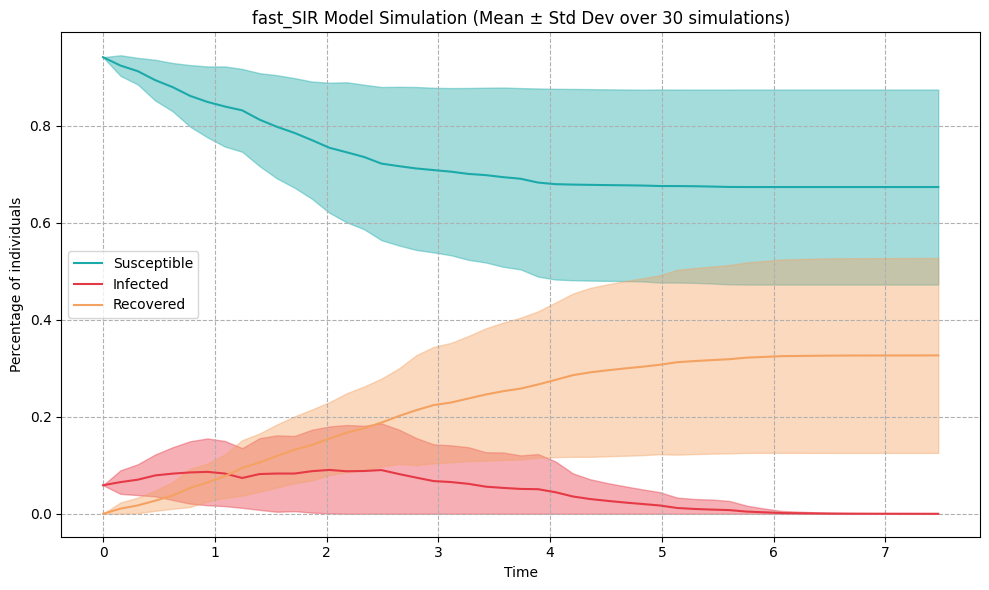

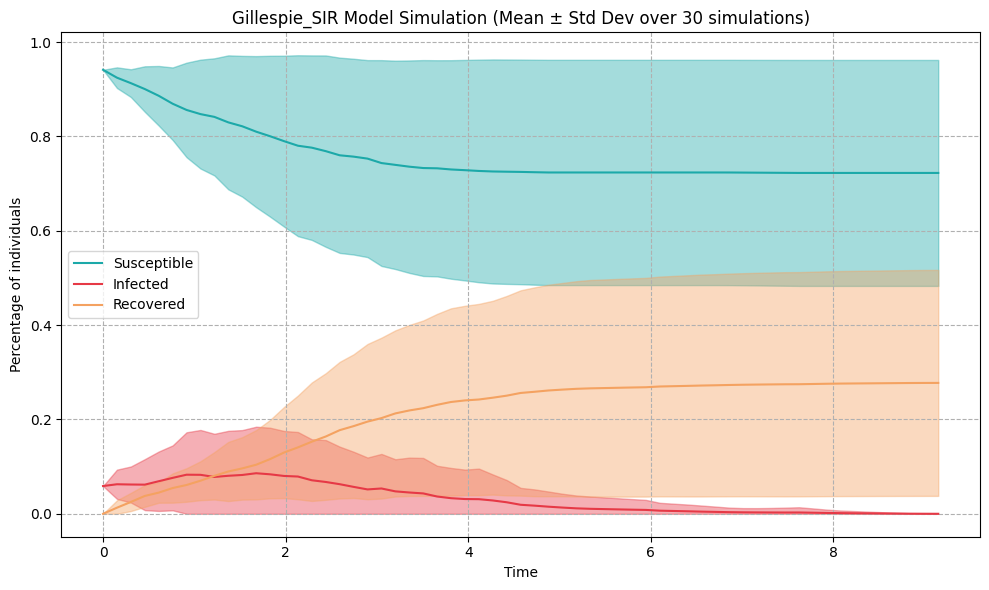

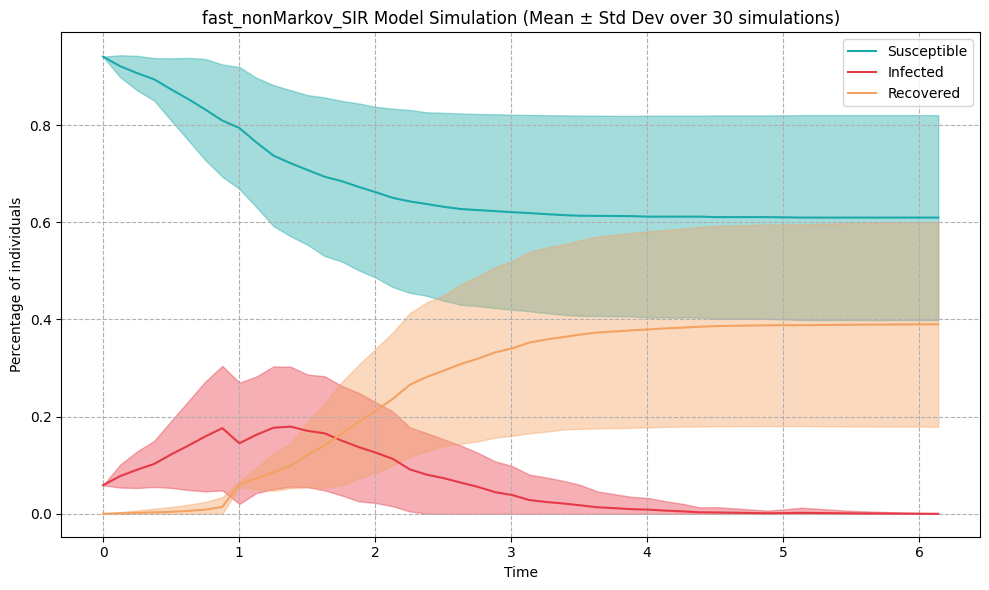

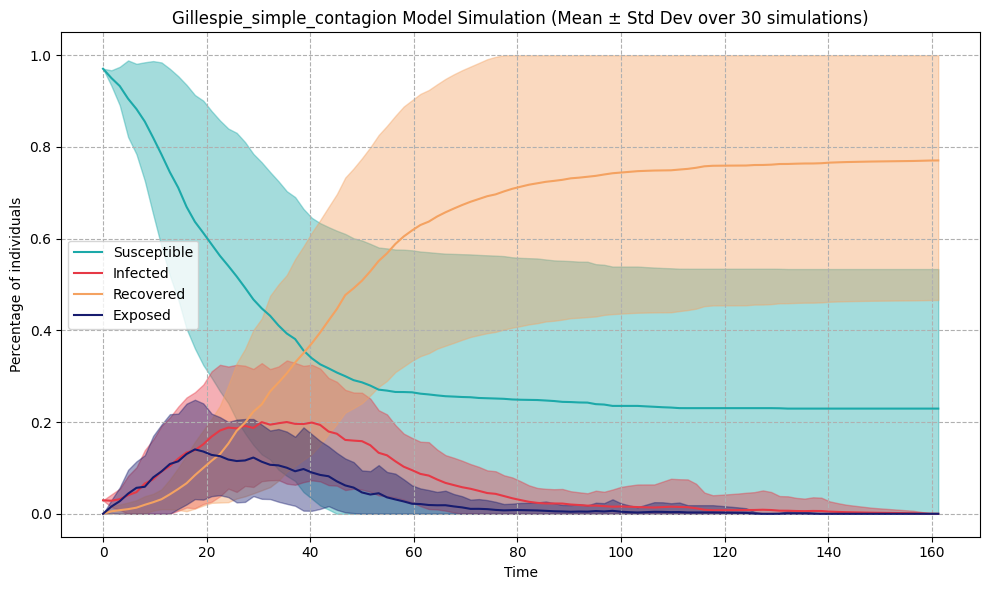

In [ ]:
for model in supported_models:
    a = InfectionSpreadModel(graph=nx.karate_club_graph(), model=model, num_simulations=30, )
    a.simulate()
    a.plot_simulations(plot_std=True)
    #a.analyze_spread_dynamics()
    # a.visualize_simulation(0, delay=0.9)

# Rewirings

## Experiments with different graphs

We do diversal experiments with different graphs for the creation of a baseline for the SEIR model, realistic and well prepared.

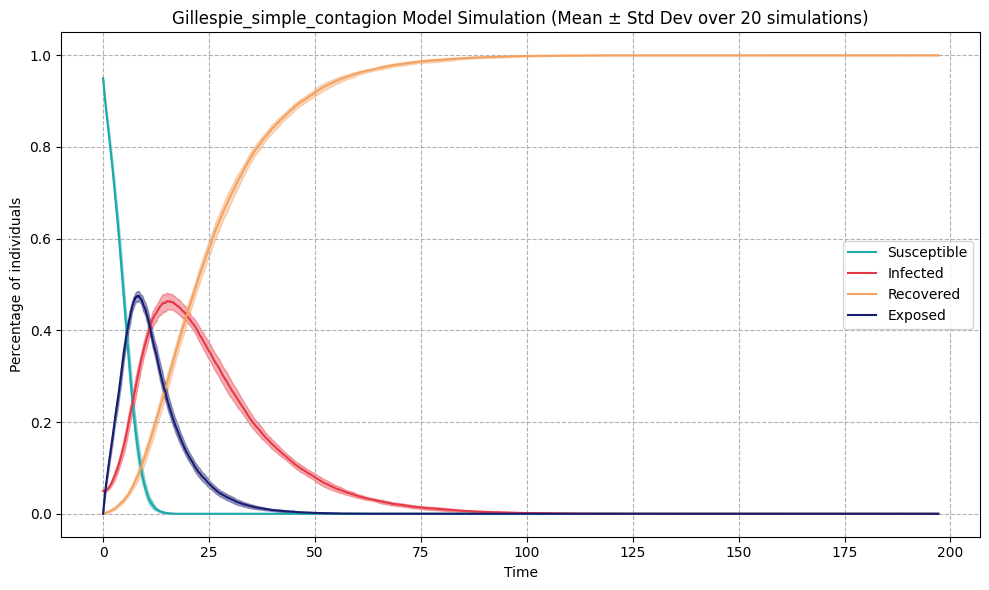


=== Infection Dynamics Analysis ===
➤ Peak infection proportion      : 0.4637
➤ Time of peak infection         : 15.57
➤ Extinction time (I < 0.001): 105.49
➤ Final attack rate (R∞)         : 1.0000
➤ Average spread speed           : 0.0275
➤ Peak exposed proportion        : 0.4751

=== Correlation with Network Centrality ===
➤ Degree       correlation (ρ)     : N/A (all nodes same status)
➤ Betweenness  correlation (ρ)     : N/A (all nodes same status)
➤ Closeness    correlation (ρ)     : N/A (all nodes same status)


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))



=== Additional Network and Infection Metrics ===
➤ Degree assortativity coefficient       : nan
➤ Average local clustering coefficient    : 0.0183
➤ Modularity of detected communities      : 0.1979

Top 5 nodes by Degree Centrality:
 Node 0: Degree=20, Infection Prob=1, Avg Infection Time=6.309685089450804
 Node 1: Degree=20, Infection Prob=1, Avg Infection Time=13.033071053650707
 Node 2: Degree=20, Infection Prob=1, Avg Infection Time=3.1978928477477133
 Node 3: Degree=20, Infection Prob=1, Avg Infection Time=5.057141990357016
 Node 4: Degree=20, Infection Prob=1, Avg Infection Time=6.904924637343531


In [ ]:
phi = 20
N = 1000
G = nx.random_regular_graph(d=phi, n=N)

a = InfectionSpreadModel(graph=G, model=supported_models[-1], num_simulations=20, )
a.simulate()
a.plot_simulations(plot_std=True)
a.analyze_spread_dynamics()

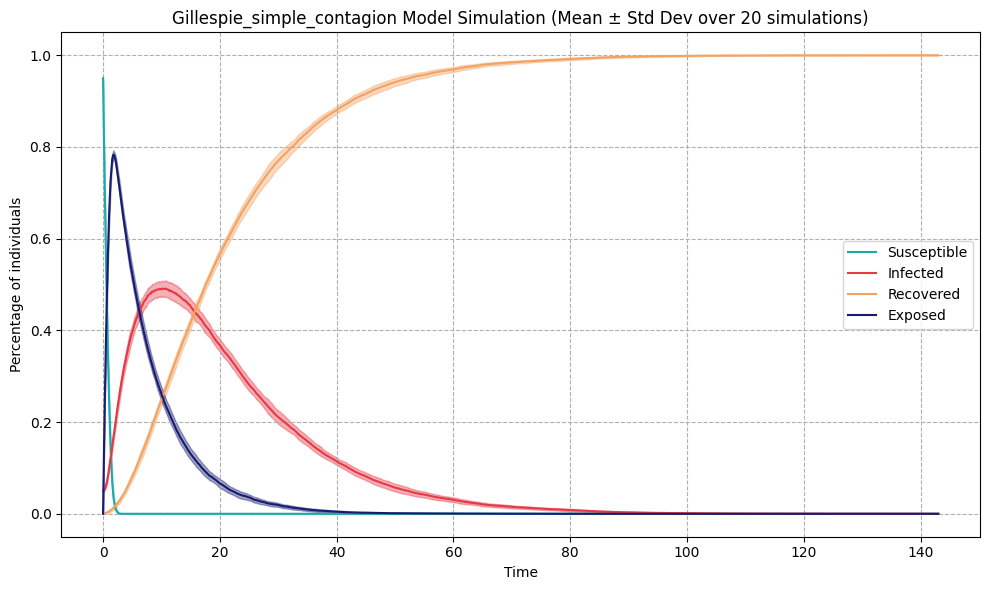


=== Infection Dynamics Analysis ===
➤ Peak infection proportion      : 0.4912
➤ Time of peak infection         : 10.65
➤ Extinction time (I < 0.001): 101.94
➤ Final attack rate (R∞)         : 1.0000
➤ Average spread speed           : 0.0430
➤ Peak exposed proportion        : 0.7829

=== Correlation with Network Centrality ===
➤ Degree       correlation (ρ)     : N/A (all nodes same status)
➤ Betweenness  correlation (ρ)     : N/A (all nodes same status)
➤ Closeness    correlation (ρ)     : N/A (all nodes same status)

=== Additional Network and Infection Metrics ===
➤ Degree assortativity coefficient       : -0.0001
➤ Average local clustering coefficient    : 0.2008
➤ Modularity of detected communities      : 0.0523

Top 5 nodes by Degree Centrality:
 Node 264: Degree=237, Infection Prob=1, Avg Infection Time=0.42238811451416597
 Node 578: Degree=233, Infection Prob=1, Avg Infection Time=0.535660721820304
 Node 767: Degree=233, Infection Prob=1, Avg Infection Time=0.37391821364570965


In [ ]:
n = 1000
p = 0.2
G = nx.erdos_renyi_graph(n, p)

a = InfectionSpreadModel(graph=G, model=supported_models[-1], num_simulations=20, )
a.simulate()
a.plot_simulations(plot_std=True)
a.analyze_spread_dynamics()

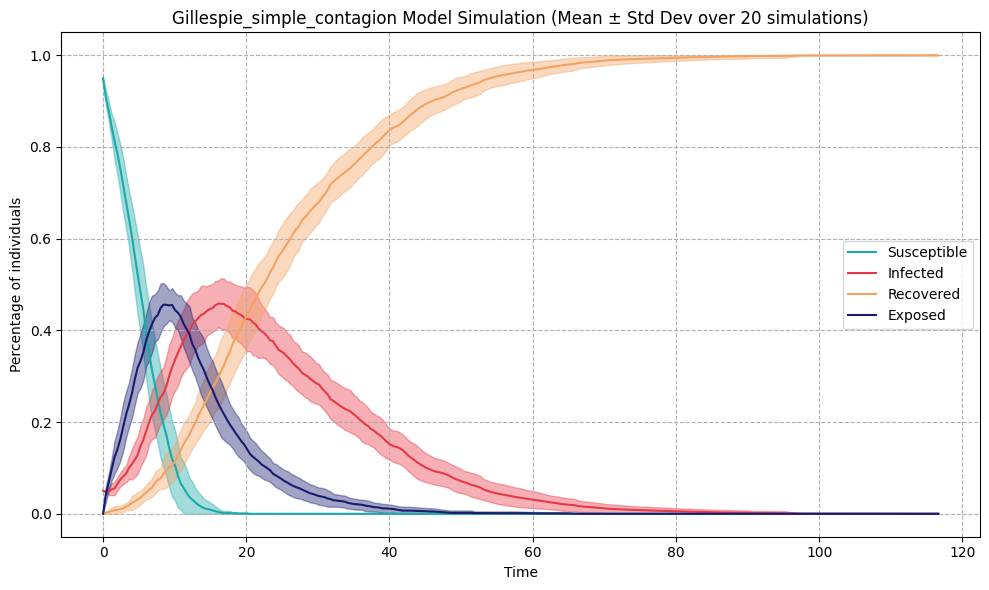


=== Infection Dynamics Analysis ===
➤ Peak infection proportion      : 0.4583
➤ Time of peak infection         : 16.49
➤ Extinction time (I < 0.001): 95.71
➤ Final attack rate (R∞)         : 1.0000
➤ Average spread speed           : 0.0261
➤ Peak exposed proportion        : 0.4562

=== Correlation with Network Centrality ===
➤ Degree       correlation (ρ)     : N/A (all nodes same status)
➤ Betweenness  correlation (ρ)     : N/A (all nodes same status)
➤ Closeness    correlation (ρ)     : N/A (all nodes same status)

=== Additional Network and Infection Metrics ===
➤ Degree assortativity coefficient       : 0.0301
➤ Average local clustering coefficient    : 0.3837
➤ Modularity of detected communities      : 0.3898

Top 5 nodes by Degree Centrality:
 Node 21: Degree=26, Infection Prob=1, Avg Infection Time=1.1183830841531035
 Node 24: Degree=25, Infection Prob=1, Avg Infection Time=0.0
 Node 26: Degree=24, Infection Prob=1, Avg Infection Time=0.8162715049339079
 Node 30: Degree=24, Inf

In [ ]:
n = 100       # population size (number of nodes)
k = 20         # each node is connected to 10 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
a = InfectionSpreadModel(graph=G, model=supported_models[-1], num_simulations=20, )
a.simulate()
a.plot_simulations(plot_std=True)
# a.visualize_simulation(0, delay=0.9)
a.analyze_spread_dynamics()

## Rewiring model

Showing watts_strogatz_graph, the chosen graph.

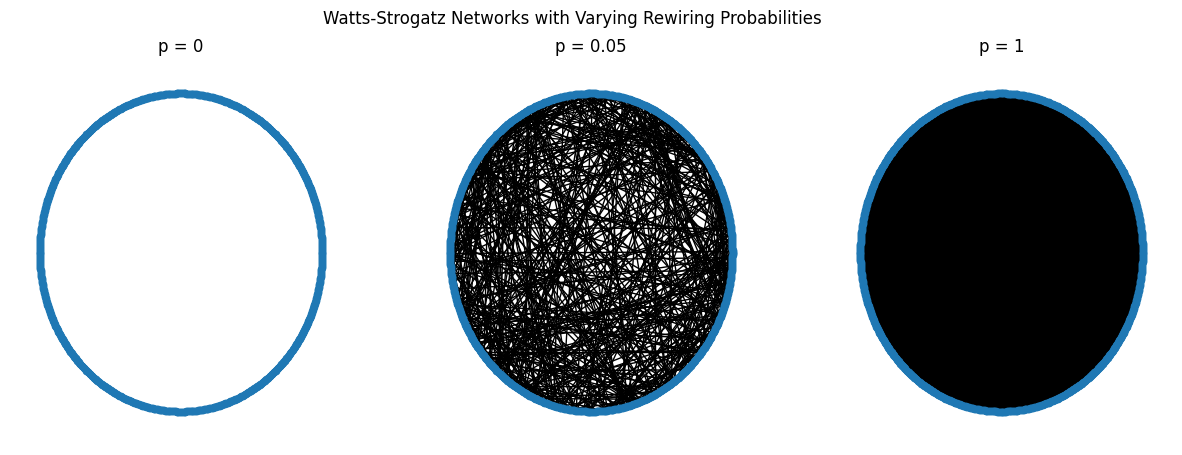

In [ ]:
# Define parameters
n = 1000
k = 20
p_values = [0, 0.05, 1]

# Set up plots
plt.figure(figsize=(15, 5))

for i, p in enumerate(p_values, 1):
    G = nx.watts_strogatz_graph(n, k, p)
    plt.subplot(1, 3, i)
    nx.draw_circular(G, node_size=20, with_labels=False)
    plt.title(f'p = {p}')

plt.suptitle('Watts-Strogatz Networks with Varying Rewiring Probabilities')
plt.show()


Study of the distributions.

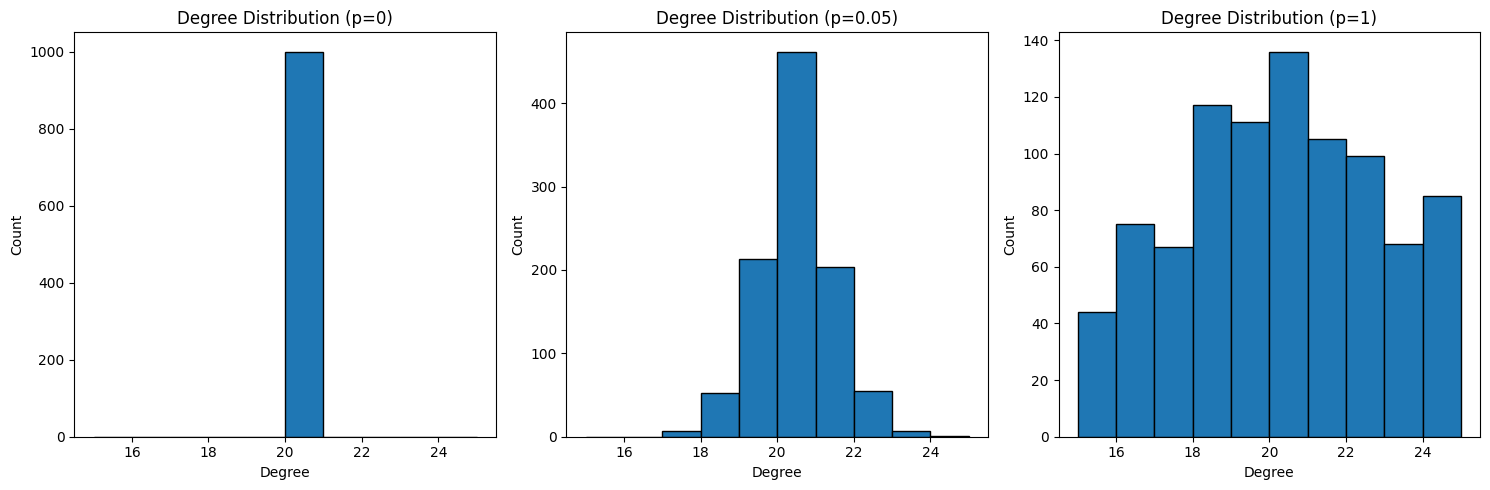

p = 0: Average shortest path length = 25.48
p = 0.05: Average shortest path length = 3.59
p = 1: Average shortest path length = 2.64


In [ ]:
# Prepare containers for results
degree_distributions = {}
avg_path_lengths = {}

for p in p_values:
    G = nx.watts_strogatz_graph(n, k, p)
    degrees = [deg for _, deg in G.degree()]
    degree_distributions[p] = degrees

    try:
        avg_path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        avg_path_length = np.nan  # For disconnected graphs

    avg_path_lengths[p] = avg_path_length

# Plot degree distributions
plt.figure(figsize=(15, 5))
for i, p in enumerate(p_values, 1):
    plt.subplot(1, 3, i)
    plt.hist(degree_distributions[p], bins=range(k-5, k+6), edgecolor='black')
    plt.title(f'Degree Distribution (p={p})')
    plt.xlabel('Degree')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display average path lengths
for p in p_values:
    print(f"p = {p}: Average shortest path length = {avg_path_lengths[p]:.2f}")


### Rewiring model

In [ ]:
"""
DynamicGraphInfectionSpreadModel
----------------------------------
Extends InfectionSpreadModel to include dynamic graph rewiring during infection spread.
Implements a rewiring mechanism where infected nodes with many susceptible neighbors
remove a fraction of their links to limit further spread.
"""

class DynamicGraphInfectionSpreadModel(InfectionSpreadModel):
    allowed_strategies = [
        'susceptible_cut', 'infected_isolate', 'random_cut', 'hub_targeting',
        'temporal_rewiring', 'rewiring_to_healthy_hubs', 'community_shielding'
    ]

    def __init__(self, rewiring = True,  rewiring_strategy='susceptible_cut', **kwargs):
        super().__init__(**kwargs)

        self.rewiring = rewiring
        if rewiring:
          if rewiring_strategy not in self.allowed_strategies:
              raise ValueError(f"Invalid rewiring_strategy: {rewiring_strategy}. Allowed: {self.allowed_strategies}")
          self.rewiring_strategy = rewiring_strategy

        self.temporarily_removed_edges = {}
        self.current_graph = None


    def simulate_with_rewiring(self, threshold = None):
        """
        Runs multiple simulations, stepping one unit at a time, modifying the network
        after each step based on node states.
        """
        print(f"[SimulateWithRewiring] Running {self.num_simulations} simulations...")
        self.ts, self.Ss, self.Is, self.Rs, self.Es, self.status_history = [], [], [], [], [], []

        for sim_idx in tqdm(range(self.num_simulations)):
            # print(f"  → Simulation {sim_idx + 1}/{self.num_simulations}")
            # Fresh copy of the graph for this simulation
            self.current_graph = self.graph.copy()

            ts, Ss, Is, Rs, Es = np.array([], dtype = np.int64), np.array([], dtype = np.int64), np.array([], dtype = np.int64), np.array([], dtype = np.int64), np.array([], dtype = np.int64)
            statuses = []

            # Initialize infection seeds
            initial_infected = random.sample(list(self.current_graph.nodes),
                                             max(1, int(self.initially_infected_fraction * self.num_nodes)))
            current_status = defaultdict(lambda: 'S', {node: 'I' for node in initial_infected})

            for t_step in range(1, self.tmax + 1):
                infected_nodes = [node for node, state in current_status.items() if state == 'I']
                recovered_nodes = [node for node, state in current_status.items() if state == 'R']
                step_model = InfectionSpreadModel(
                    graph=self.current_graph,
                    model=self.model,
                    tmin=self.tmin + t_step,
                    tmax=self.tmin + t_step + 1,
                    num_simulations=1,
                    IC=current_status,
                )

                simts, simSs, simIs, simRs, simEs = step_model.simulate(infected_nodes, recovered_nodes)
                self.R = step_model.R
                self.E = step_model.E
                ts = np.concatenate((ts, simts[0]))
                Is = np.concatenate((Is, simIs[0]))
                if self.R:
                    Rs = np.concatenate((Rs, simRs[0]))
                if self.E:
                    Es = np.concatenate((Es, simEs[0]))
                    Ss = np.concatenate((Ss, simSs[0]))

                # Last snapshot for rewiring and next step
                last_snapshot = step_model.status_history[0][-1]
                #statuses.append(step_model.status_history[0])

                if self.rewiring:
                  self.modify_graph(t_step, last_snapshot, threshold)

                # Prepare updated current_status for next step
                current_status = defaultdict(lambda: 'S', last_snapshot)

            #print(list(zip(list(Ss), Is, Rs)))

            if self.R and not self.E:
              N = self.num_nodes
              S_step = N - Is - Rs
              Ss = np.concatenate((Ss, S_step))
            self.ts.append(ts)
            self.Ss.append(Ss)
            self.Is.append(Is)
            self.Rs.append(Rs)
            self.Es.append(Es)
            #self.status_history.append(statuses)

            self.recap()

        print("[SimulateWithRewiring] All simulations completed.")

    def modify_graph(self, t_step, current_status=None, t=0):
        """
        Applies the selected rewiring strategy at each even step.
        - susceptible_cut: susceptibles cut ties to infected neighbors.
        - infected_isolate: infected nodes cut all their edges.
        - random_cut: randomly removes 5% of all edges.
        - hub_targeting: removes connections of top-degree nodes.
        - temporal_rewiring: temporarily disables risky edges.
        - rewiring_to_healthy_hubs: redirects edges to low-degree, uninfected hubs.
        - community_shielding: reduces inter-community links.
        """
        if t_step % 2 != 0:
            return

        if self.rewiring_strategy == 'susceptible_cut':
            self.susceptible_cut(current_status, t)

        elif self.rewiring_strategy == 'infected_isolate':
            self.infected_isolate(current_status)

        elif self.rewiring_strategy == 'random_cut':
            self.random_cut()

        elif self.rewiring_strategy == 'hub_targeting':
            self.hub_targeting(t)

        elif self.rewiring_strategy == 'temporal_rewiring':
            self.temporal_rewiring(current_status, t_step)

        elif self.rewiring_strategy == 'rewiring_to_healthy_hubs':
            self.rewiring_to_healthy_hubs(current_status, t)

        elif self.rewiring_strategy == 'community_shielding':
            self.community_shielding()

    def susceptible_cut(self, current_status, threshold, x=0.6):
        """
        At every even time step, infected nodes with more than a threshold
        of susceptible neighbors will randomly cut x% of those edges. -> “avoid the sick” behavior.
        """
        for node in self.current_graph.nodes:
            if current_status.get(node, 'S') == 'S':
                infected_neighbors = [nbr for nbr in self.current_graph.neighbors(node)
                                      if current_status.get(nbr, 'S') == 'I']
                if len(infected_neighbors) >= threshold:
                    to_remove = random.sample(infected_neighbors, max(1, int(x * len(infected_neighbors))))
                    self.current_graph.remove_edges_from([(node, nbr) for nbr in to_remove])

    def infected_isolate(self, current_status):
        """
        Infected nodes voluntarily drop all their outgoing edges (self-isolation or quarantine) -> Mimics total lockdown or hospitalization.
        """
        for node in self.current_graph.nodes:
            if current_status.get(node, 'S') == 'I':
                self.current_graph.remove_edges_from([(node, nbr) for nbr in list(self.current_graph.neighbors(node))])

    def random_cut(self):
        """
        Cut random edges periodically to break up large clusters, regardless of infection status. -> Blind strategy but sometimes surprisingly effective.
        """
        edges = list(self.current_graph.edges)
        num_to_remove = max(1, int(0.1 * len(edges)))
        to_remove = random.sample(edges, num_to_remove)
        self.current_graph.remove_edges_from(to_remove)

    def hub_targeting(self, n):
        """
        Identify *n* high-degree infected nodes (super-spreaders) and remove as many of their links as possible. -> Strategic attack on the transmission backbone.
        """
        degrees = dict(self.current_graph.degree())
        sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)[:n]
        for node in sorted_nodes:
            self.current_graph.remove_edges_from([(node, nbr) for nbr in list(self.current_graph.neighbors(node))])

    def temporal_rewiring(self, current_status, t_step):
        """
        Edges are not permanently cut but temporarily deactivated — for example, “pause” interactions for 10 days if risk is high, then restore. -> Mimics real-world social distancing.
        """
        # Temporarily deactivate edges (store separately if needed)
        for node in self.current_graph.nodes:
            # Restore expired edges first
            expired = [(edge, expire_t) for edge, expire_t in self.temporarily_removed_edges.items() if t_step >= expire_t]
            for edge, _ in expired:
                self.current_graph.add_edge(*edge)
                del self.temporarily_removed_edges[edge]

            # Now temporarily remove risky edges
            for node in self.current_graph.nodes:
                if current_status.get(node, 'S') == 'S':
                    risky_edges = [(node, nbr) for nbr in self.current_graph.neighbors(node)
                                  if current_status.get(nbr, 'S') == 'I']
                    for edge in risky_edges:
                        self.current_graph.remove_edge(*edge)
                        self.temporarily_removed_edges[edge] = t_step + 5

    def rewiring_to_healthy_hubs(self, current_status, n_healthy_neighbours=5):
        """
        When a susceptible cuts a risky edge, it forms a new connection — but preferentially to a low-risk node (someone with no infected neighbors). -> Maintains social connectivity while avoiding risk.
        """
        healthy_nodes = [n for n in self.current_graph.nodes if current_status.get(n, 'S') == 'S']
        low_degree = sorted(healthy_nodes, key=lambda n: self.current_graph.degree(n), reverse=True)[:n_healthy_neighbours]
        for node in self.current_graph.nodes:
            if current_status.get(node, 'S') == 'S':
                infected_neighbors = [nbr for nbr in self.current_graph.neighbors(node)
                                      if current_status.get(nbr, 'S') == 'I']
                for nbr in infected_neighbors:
                    self.current_graph.remove_edge(node, nbr)
                    if low_degree:
                        new_target = random.choice(low_degree)
                        self.current_graph.add_edge(node, new_target)

    def community_shielding(self):
        """
        Rewire edges to reduce inter-community (between-group) connections but preserve intra-community ties. -> Limits cross-cluster outbreaks.
        """
        communities = list(nx.community.greedy_modularity_communities(self.current_graph))
        inter_edges = [(u, v) for u, v in self.current_graph.edges if not any(u in c and v in c for c in communities)]
        if inter_edges:
          num_to_remove = min(len(inter_edges), max(1, int(0.1 * len(inter_edges))))
          to_remove = random.sample(inter_edges, num_to_remove)
          self.current_graph.remove_edges_from(to_remove)
        else:
           print("[Warning] No inter-community edges found; skipping community_shielding step.")


    def recap(self):
      pass




[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


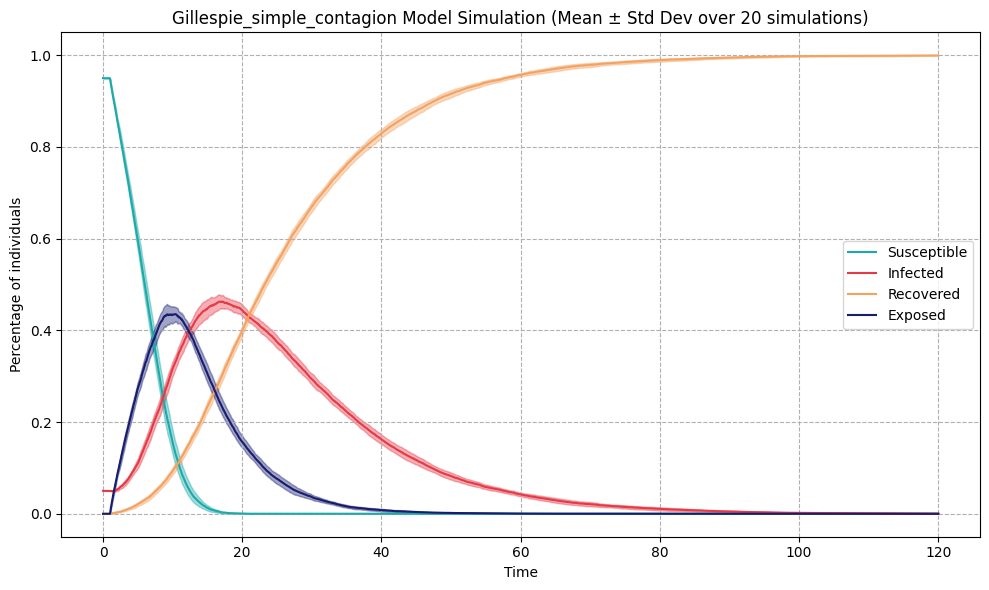

In [ ]:
n = 1000      # total number of nodes in the graph (i.e., the population size).
k = 20        # each node is connected to 10 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
b = DynamicGraphInfectionSpreadModel(rewiring = False, graph=G, model=supported_models[-1], num_simulations=20, tmax=120)
b.simulate_with_rewiring()
b.plot_simulations(plot_std=True)
#a.analyze_spread_dynamics()

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


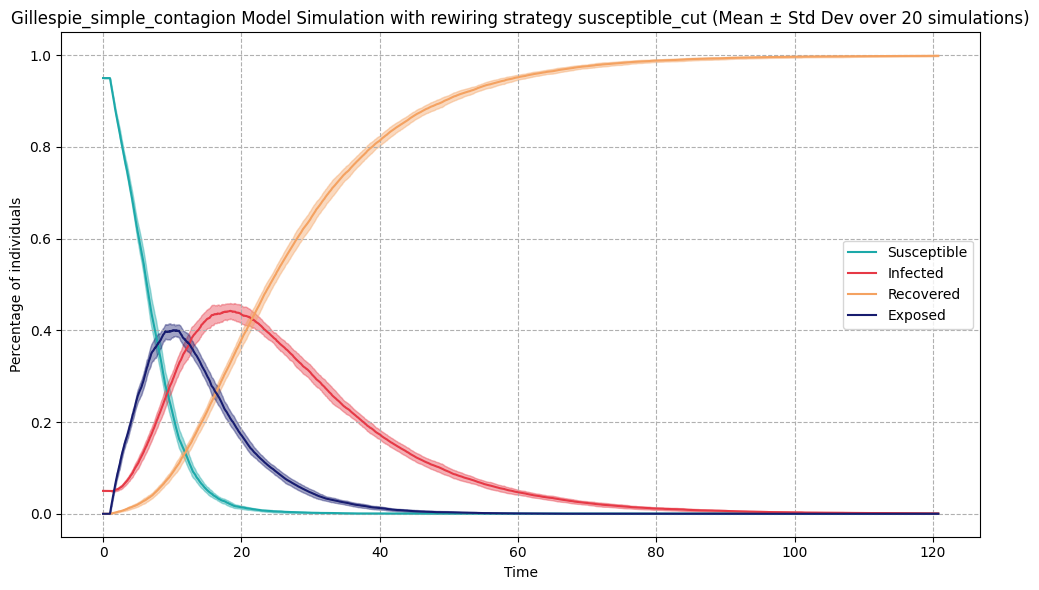

In [ ]:
n = 1000      # total number of nodes in the graph (i.e., the population size).
k = 20        # each node is connected to 20 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
t, n_sim = 3, 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='susceptible_cut', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring(t)
b.plot_simulations(plot_std=True, rewiring_strategy='susceptible_cut', n_sim=n_sim)
#a.analyze_spread_dynamics()

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


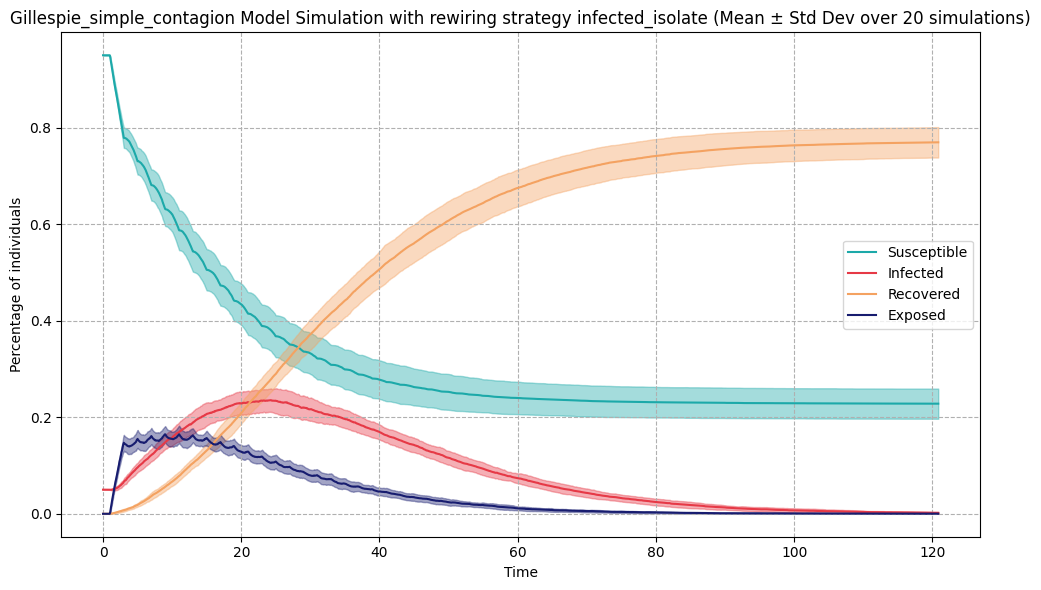

In [ ]:
n = 1000
k = 20
p = 0.2

G = nx.watts_strogatz_graph(n, k, p)
n_sim = 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='infected_isolate', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring()
b.plot_simulations(plot_std=True, rewiring_strategy='infected_isolate', n_sim=n_sim)

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


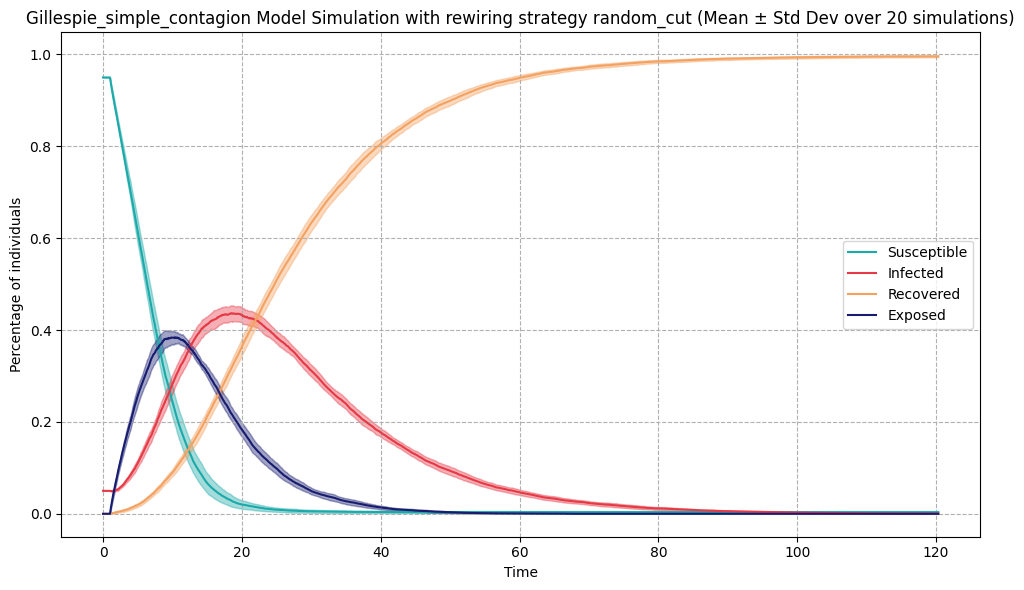

In [ ]:
n = 1000
k = 20
p = 0.2

G = nx.watts_strogatz_graph(n, k, p)
n_sim = 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='random_cut', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring()
b.plot_simulations(plot_std=True, rewiring_strategy='random_cut', n_sim=n_sim)

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


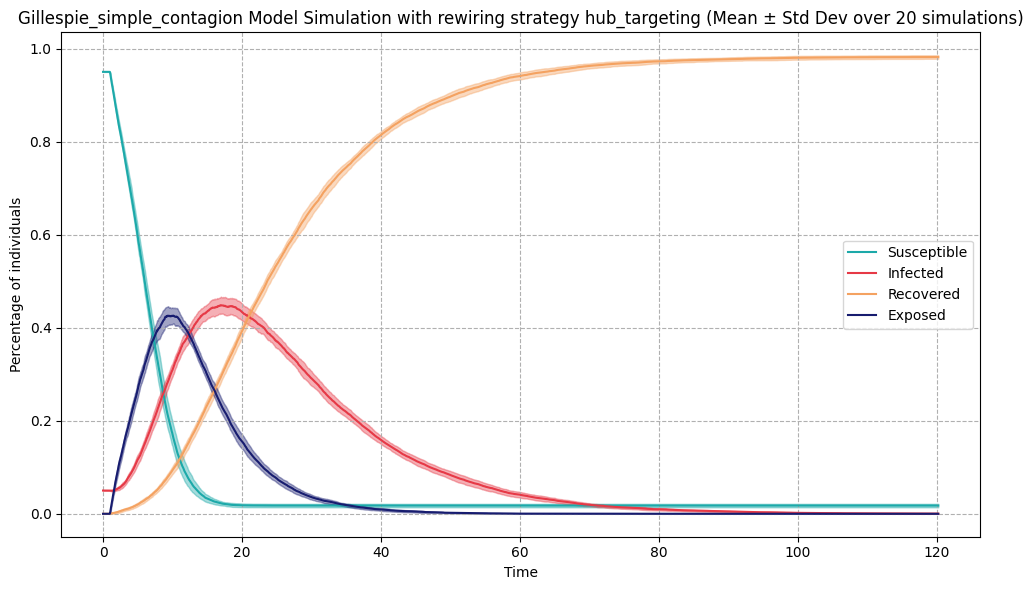

In [ ]:
n = 1000      # total number of nodes in the graph (i.e., the population size).
k = 20        # each node is connected to 10 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
n, n_sim = 10, 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='hub_targeting', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring(n)
b.plot_simulations(plot_std=True, rewiring_strategy='hub_targeting', n_sim=n_sim)
#a.analyze_spread_dynamics()

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


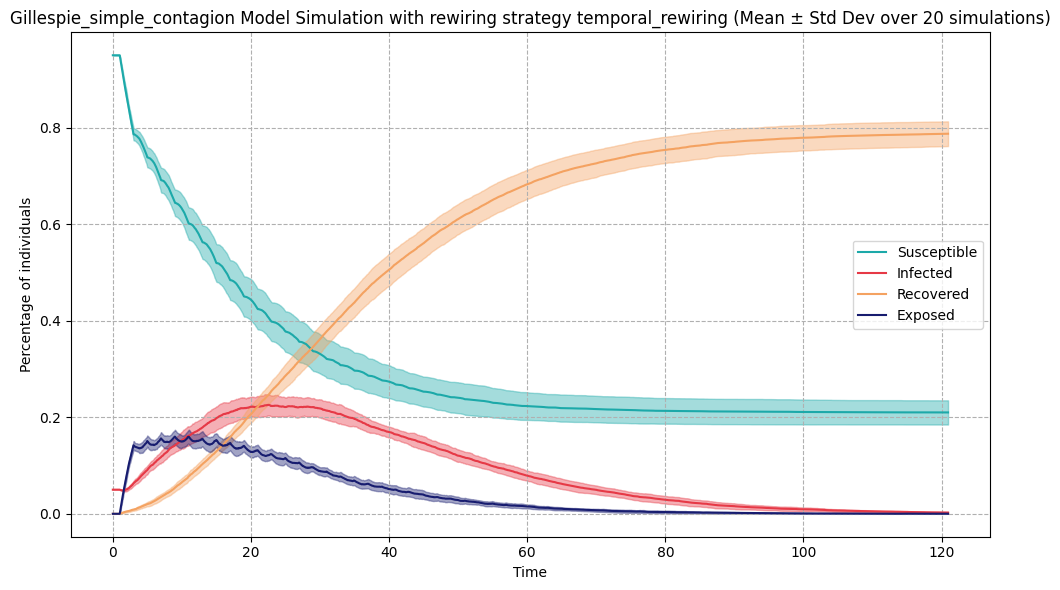

In [ ]:
n = 1000
k = 20
p = 0.2

G = nx.watts_strogatz_graph(n, k, p)
n_sim = 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='temporal_rewiring', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring()
b.plot_simulations(plot_std=True, rewiring_strategy='temporal_rewiring', n_sim=n_sim)

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


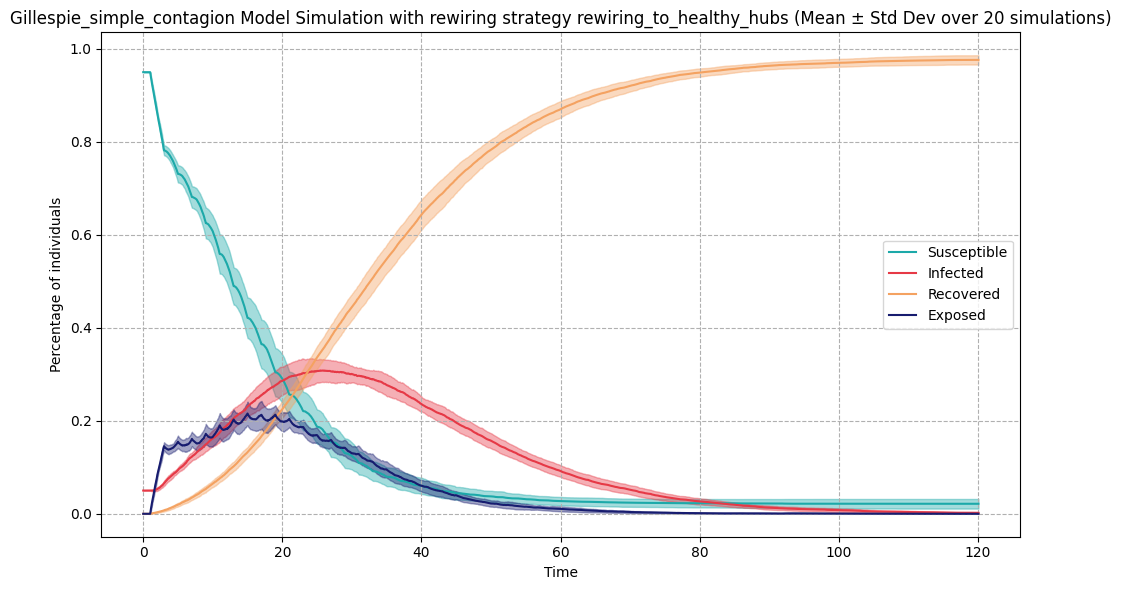

In [ ]:
n = 1000      # total number of nodes in the graph (i.e., the population size).
k = 20        # each node is connected to 10 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
t, n_sim = 5, 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='rewiring_to_healthy_hubs', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring(t)
b.plot_simulations(plot_std=True, rewiring_strategy='rewiring_to_healthy_hubs', n_sim=n_sim)
#a.analyze_spread_dynamics()

[SimulateWithRewiring] Running 20 simulations...


  0%|          | 0/20 [00:00<?, ?it/s]

[SimulateWithRewiring] All simulations completed.


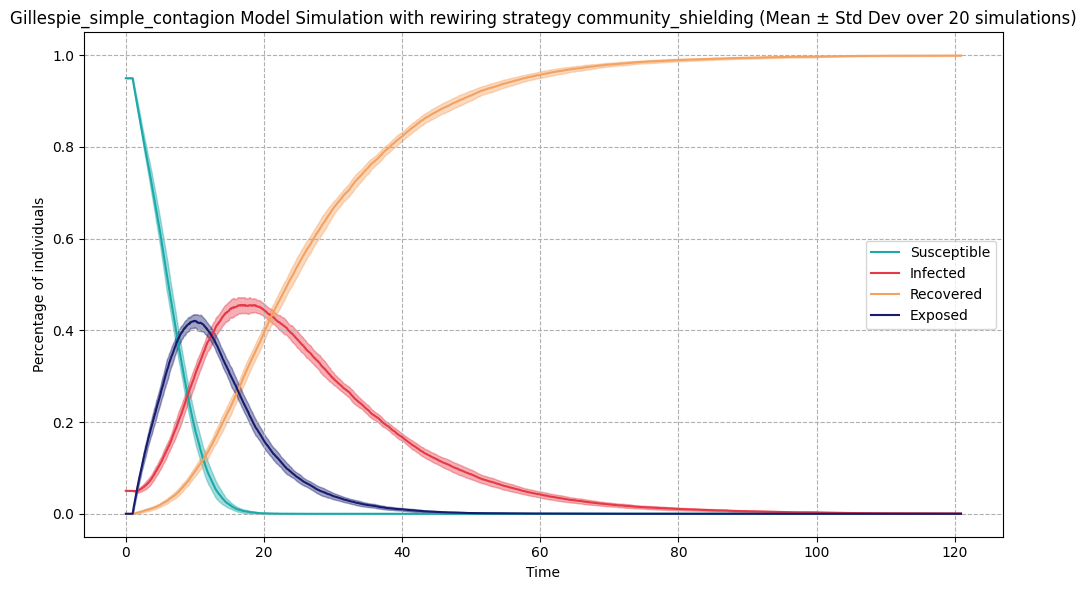

In [ ]:
n = 1000      # total number of nodes in the graph (i.e., the population size).
k = 20        # each node is connected to 10 nearest neighbors in a ring (5 on each side)
p = 0.2       # 20% probability of rewiring each edge

G = nx.watts_strogatz_graph(n, k, p)
n_sim = 20
b = DynamicGraphInfectionSpreadModel(rewiring = True, rewiring_strategy='community_shielding', graph=G, model=supported_models[-1], num_simulations=n_sim, tmax=120)
b.simulate_with_rewiring()
b.plot_simulations(plot_std=True, rewiring_strategy='community_shielding', n_sim=n_sim)
#a.analyze_spread_dynamics()